## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████████████████████| 26421880/26421880 [00:04<00:00, 6204527.06it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 349119.22it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|████████████████████████████| 4422102/4422102 [00:01<00:00, 3134446.70it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|█████████████████████████████████| 5148/5148 [00:00<00:00, 28114944.00it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [9]:
for img, label in train_loader:
    print(f'Image shape {img.shape}')
    print(f'label shape {label.shape}')
    print(f'label sizw {label.size(0)}')
    break

Image shape torch.Size([128, 1, 28, 28])
label shape torch.Size([128])
label sizw 128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [39]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(TinyNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
            
            
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            test_correct += (predicted == labels).sum().item()
            test_accuracy = test_correct / len(fmnist_dataset_test)
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(fmnist_dataset_test)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Train Loss: 0.4736, Train Accuracy: 0.8483, Test Accuracy: 0.8633
Epoch [2/10], Train Loss: 0.3301, Train Accuracy: 0.8854, Test Accuracy: 0.8752
Epoch [3/10], Train Loss: 0.2903, Train Accuracy: 0.8987, Test Accuracy: 0.8827
Epoch [4/10], Train Loss: 0.2648, Train Accuracy: 0.9072, Test Accuracy: 0.8836
Epoch [5/10], Train Loss: 0.2443, Train Accuracy: 0.9145, Test Accuracy: 0.8861
Epoch [6/10], Train Loss: 0.2280, Train Accuracy: 0.9197, Test Accuracy: 0.8889
Epoch [7/10], Train Loss: 0.2145, Train Accuracy: 0.9261, Test Accuracy: 0.8948
Epoch [8/10], Train Loss: 0.2017, Train Accuracy: 0.9301, Test Accuracy: 0.8879
Epoch [9/10], Train Loss: 0.1910, Train Accuracy: 0.9337, Test Accuracy: 0.8928
Epoch [10/10], Train Loss: 0.1796, Train Accuracy: 0.9388, Test Accuracy: 0.8953


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [48]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes) )
    def forward(self, inp):
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            test_correct += (predicted == labels).sum().item()
            test_accuracy = test_correct / len(fmnist_dataset_test)
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(fmnist_dataset_test)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/40], Train Loss: 0.4689, Train Accuracy: 0.8495, Test Accuracy: 0.8572
Epoch [2/40], Train Loss: 0.3305, Train Accuracy: 0.8869, Test Accuracy: 0.8681
Epoch [3/40], Train Loss: 0.2915, Train Accuracy: 0.8977, Test Accuracy: 0.8766
Epoch [4/40], Train Loss: 0.2661, Train Accuracy: 0.9069, Test Accuracy: 0.8577
Epoch [5/40], Train Loss: 0.2461, Train Accuracy: 0.9134, Test Accuracy: 0.8853
Epoch [6/40], Train Loss: 0.2289, Train Accuracy: 0.9207, Test Accuracy: 0.8887
Epoch [7/40], Train Loss: 0.2147, Train Accuracy: 0.9263, Test Accuracy: 0.8888
Epoch [8/40], Train Loss: 0.2023, Train Accuracy: 0.9304, Test Accuracy: 0.8866
Epoch [9/40], Train Loss: 0.1902, Train Accuracy: 0.9346, Test Accuracy: 0.8822
Epoch [10/40], Train Loss: 0.1801, Train Accuracy: 0.9391, Test Accuracy: 0.8936
Epoch [11/40], Train Loss: 0.1723, Train Accuracy: 0.9413, Test Accuracy: 0.8922
Epoch [12/40], Train Loss: 0.1627, Train Accuracy: 0.9447, Test Accuracy: 0.8925
Epoch [13/40], Train Loss: 0.1538, Tr

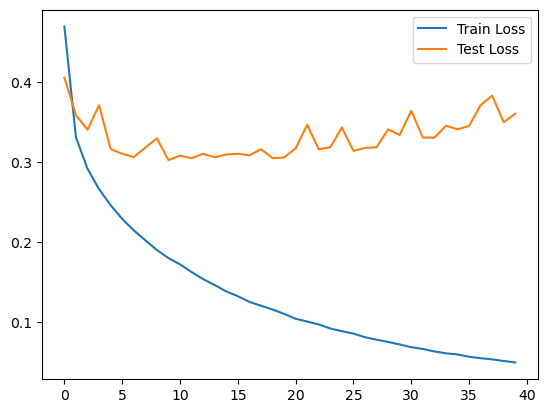

In [49]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['Train Loss', 'Test Loss'])

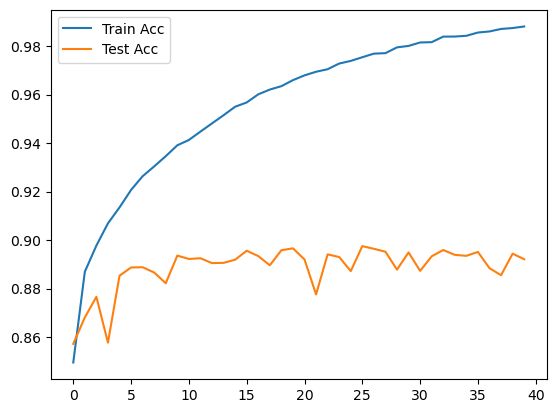

In [50]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['Train Acc', 'Test Acc'])

# Вывод:
Как мы видим, модель не улучшается на тесте,а на трейне просто запоминает выборку. Два графика сверху символизируют о переобучении.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [59]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(FixedNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 500),
            nn.BatchNorm1d(500),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(100, num_classes) )
    def forward(self, inp):
        out = self.model(inp)
        return out

model = FixedNeuralNetwork().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Training loop
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(fmnist_dataset_train)
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_loss = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            test_correct += (predicted == labels).sum().item()
            test_accuracy = test_correct / len(fmnist_dataset_test)
    test_loss /= len(test_loader)
    test_accuracy = test_correct / len(fmnist_dataset_test)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/40], Train Loss: 0.7482, Train Accuracy: 0.7741, Test Accuracy: 0.8268
Epoch [2/40], Train Loss: 0.5607, Train Accuracy: 0.8203, Test Accuracy: 0.8447
Epoch [3/40], Train Loss: 0.5171, Train Accuracy: 0.8314, Test Accuracy: 0.8509
Epoch [4/40], Train Loss: 0.4890, Train Accuracy: 0.8376, Test Accuracy: 0.8527
Epoch [5/40], Train Loss: 0.4719, Train Accuracy: 0.8430, Test Accuracy: 0.8595
Epoch [6/40], Train Loss: 0.4610, Train Accuracy: 0.8460, Test Accuracy: 0.8572
Epoch [7/40], Train Loss: 0.4507, Train Accuracy: 0.8485, Test Accuracy: 0.8616
Epoch [8/40], Train Loss: 0.4409, Train Accuracy: 0.8505, Test Accuracy: 0.8627
Epoch [9/40], Train Loss: 0.4331, Train Accuracy: 0.8535, Test Accuracy: 0.8644
Epoch [10/40], Train Loss: 0.4296, Train Accuracy: 0.8540, Test Accuracy: 0.8662
Epoch [11/40], Train Loss: 0.4207, Train Accuracy: 0.8571, Test Accuracy: 0.8683
Epoch [12/40], Train Loss: 0.4144, Train Accuracy: 0.8595, Test Accuracy: 0.8688
Epoch [13/40], Train Loss: 0.4147, Tr

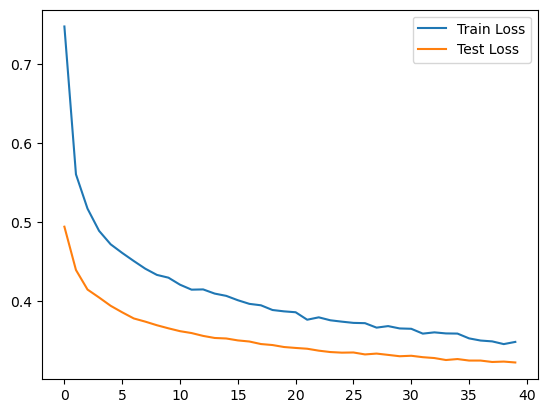

In [60]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['Train Loss', 'Test Loss'])

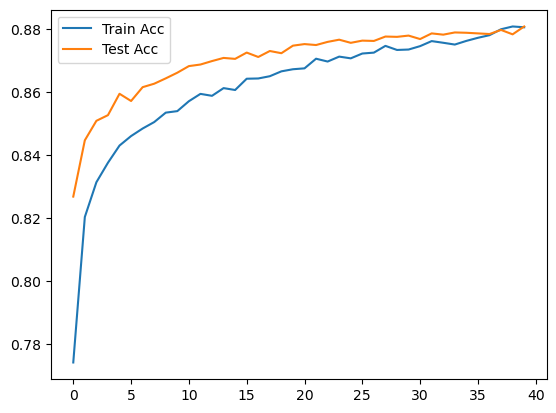

In [61]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['Train Acc', 'Test Acc'])

### Conclusions:
Как мы видим, довольно радикальное решение (в виде дропаута с большой вероятностью) помогает модели не переобучаться. Хотя следует отметить, что на таком простом датасете сложно не переобучиться хоть сколько нибудь простой модели.